In [1]:
# import numpy as np
import autograd.numpy as np
from autograd import grad
import matplotlib 
import matplotlib as mpl

from astropy.table import Table

import manhattan.periodograms as cs 
from exotk.utils.misc import fold

%pylab inline --no-import-all
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['figure.figsize']=(10.0,10.0)    #(6.0,4.0)
matplotlib.rcParams['font.size']=16              #10 
matplotlib.rcParams['savefig.dpi']= 300             #72 
matplotlib.rcParams['axes.facecolor']='white'
matplotlib.rcParams['savefig.facecolor']='white'

colours = mpl.rcParams['axes.color_cycle'] 


Populating the interactive namespace from numpy and matplotlib


/Users/benjaminpope/anaconda2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['np']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"
/Users/benjaminpope/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:830: MatplotlibDeprecationWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  mplDeprecation)


## Basis Pursuit for Spectrum Estimation

Following Chen & Donoho, "APPLICATION OF BASIS PURSUIT IN SPECTRUM ESTIMATION"

https://pdfs.semanticscholar.org/1bb0/74529d4a5d56cc9d05befcc3dcde957420fb.pdf

We want to be able to infer the power spectrum of a signal which is sparse in the Fourier domain, given potentially sparse, irregularly sampled time series. Using an L1 norm algorithm, we can fit simultaneously a sum of sines, cosines, polynomial terms, and Dirac delta functions to represent outliers, and get a pretty decent fit.

We have a similar approach to Hara et al., 'Radial velocity data analysis with compressed sensing techniques'.

http://adsabs.harvard.edu/abs/2017MNRAS.464.1220H

In [2]:
time = np.linspace(0,100,1000)
y = np.zeros_like(time)

inputs = [1.,2., 2.5, 4.3] # to do it manually
amps = [1., 0.2, 3., 0.5]

inputs = np.random.rand(10)*5. # to randomly generate some frequencies
amps = np.random.rand(10)+0.5

for j, f in enumerate(inputs): 
    y += amps[j]*np.sin(f*time)
    
snr = 50. # dial it down to add more white noise

y += (y.max()/snr) * np.random.randn(len(y))

y = (y-y.min())/(y.max()-y.min())

args = np.sort(np.random.choice(len(time),size=100,replace=False)) # only choose 100 points, at random

tt, yy = time[args], y[args]


In [3]:
np.unique(args).shape

(100,)

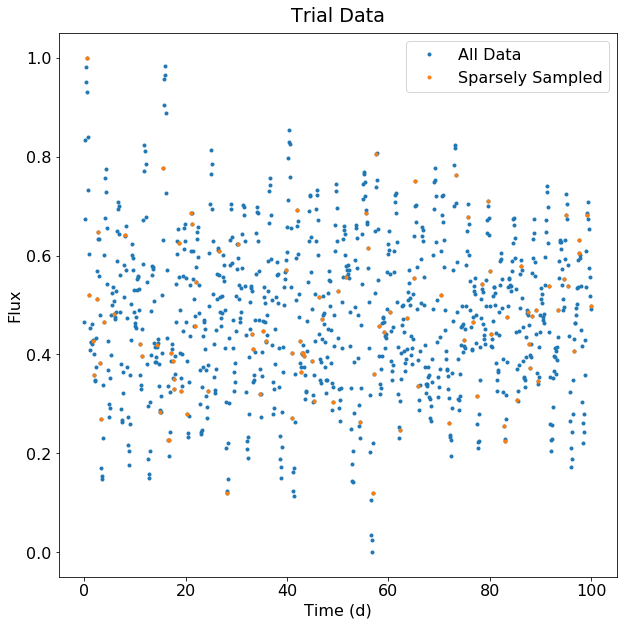

In [4]:
plt.plot(time,y,'.',label="All Data")
plt.plot(tt,yy,'.',label="Sparsely Sampled")
plt.xlabel("Time (d)")
plt.ylabel("Flux")
plt.legend()
plt.title("Trial Data",y=1.01);

### For basis pursuit: 
https://github.com/drrelyea/SPGL1_python_port 

### minimize ||x||_1 subject to Ax = b




In [5]:
%%time
output = cs.basis_pursuit(tt,yy,nfreqs=500,fmin=0.1,fmax=10,polyorder=2)

CPU times: user 470 ms, sys: 19.8 ms, total: 490 ms
Wall time: 479 ms


In [6]:
power = (output['sines']**2 + output['cosines']**2)
freqs = output['freqs']
diracs = output['diracs']
polys = output['polys']
residuals = output['resid']
print output['polys']

[-2.88110471e-08 -2.87234989e-08 -8.92209004e-02]


In [7]:
pf = np.poly1d(polys)

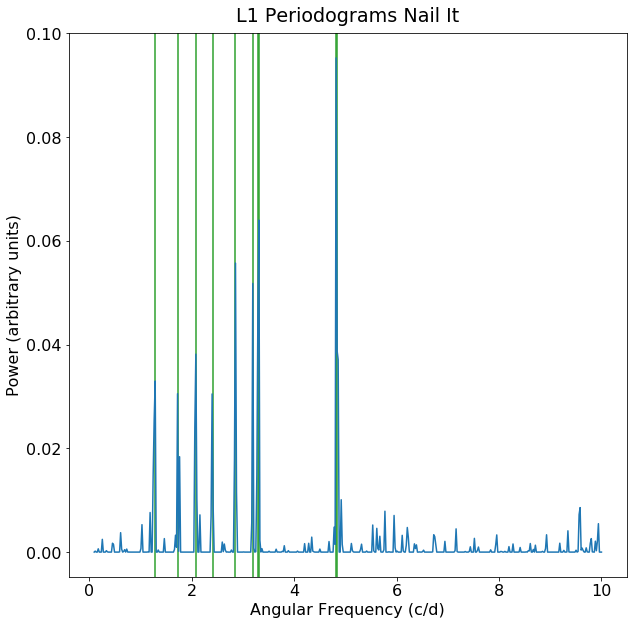

In [8]:
# plt.plot(freqs,sines)
# plt.plot(freqs,cosines)
for f in inputs:
    plt.axvline(f,color=colours[2])
    
plt.plot(freqs,np.sqrt(power))
plt.xlabel("Angular Frequency (c/d)")
plt.ylabel("Power (arbitrary units)")
plt.title("L1 Periodograms Nail It", y=1.01);

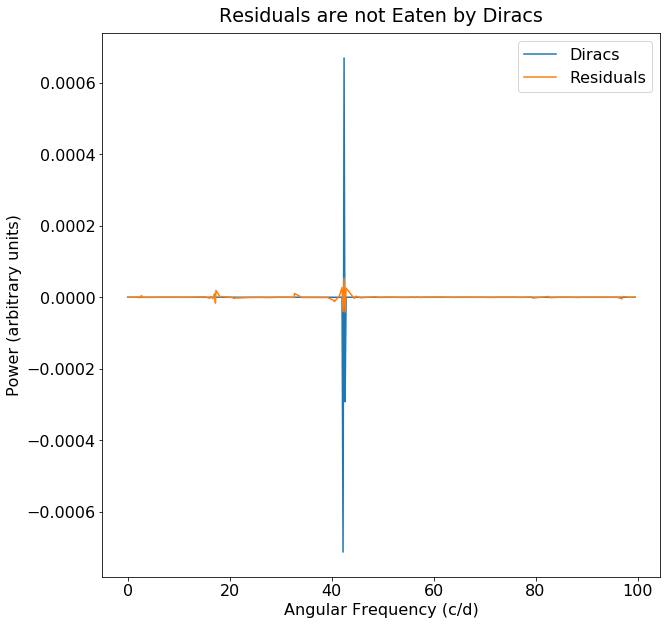

In [9]:
plt.plot(tt,diracs,label="Diracs")
plt.plot(tt,residuals,label="Residuals")
plt.xlabel("Angular Frequency (c/d)")
plt.ylabel("Power (arbitrary units)")
plt.legend()
plt.title("Residuals are not Eaten by Diracs",y=1.01);

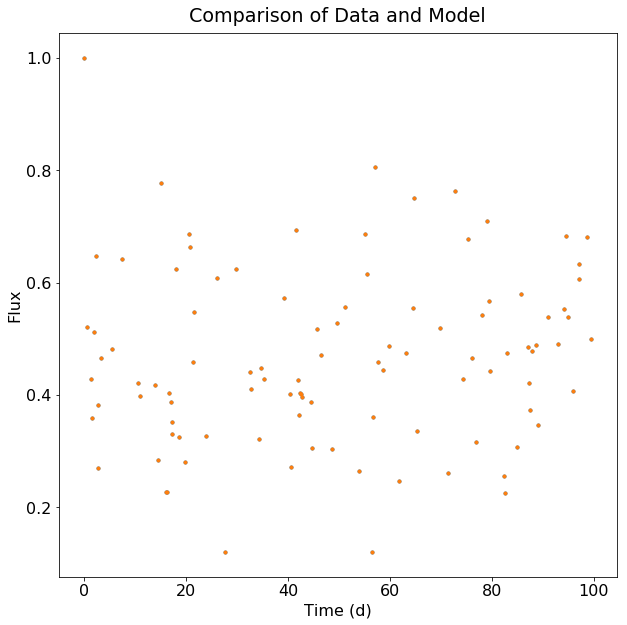

In [10]:
plt.title("Comparison of Data and Model",y=1.01)
plt.plot(tt,yy,'.')
plt.plot(tt,output['model'],'.')
plt.xlabel("Time (d)")
plt.ylabel("Flux");

### How does this perform as you reduce the number of samples?

In [11]:
%%time
recovered = []
sizes = [10,20,30,40,50,100,200,500,1000]

ys = np.sin(time)

for sz in sizes:
    args = np.sort(np.random.choice(len(time),size=sz,replace=False))

    tt, yy = time[args], ys[args]
    output = cs.basis_pursuit(tt,yy)
    power = (output['sines']**2 + output['cosines']**2)
    freqs = output['freqs']
    
    recovered.append(freqs[np.argmax(power)])

CPU times: user 30.8 s, sys: 497 ms, total: 31.2 s
Wall time: 17.2 s


Text(0.5,1.01,u"You don't need many samples and you can recover the frequency to ~0.1%")

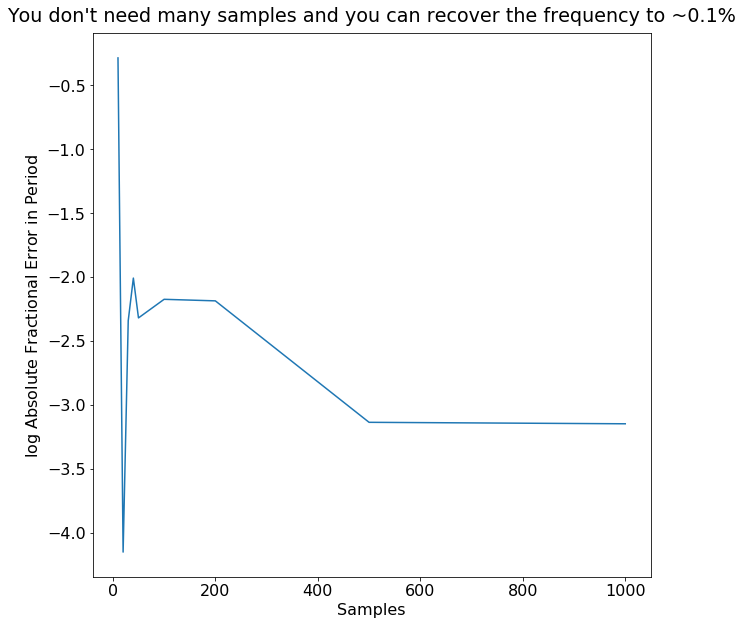

In [12]:
plt.plot(sizes,np.log10(np.abs(1.-np.array(recovered))))
plt.ylabel(r"$\log$ Absolute Fractional Error in Period")
plt.xlabel("Samples")
plt.title("You don't need many samples and you can recover the frequency to ~0.1%",y=1.01)

### How does this perform on real data?

In [13]:
ls /Users/benjaminpope/code/csperiodograms/data/HR7487/

ls: /Users/benjaminpope/code/csperiodograms/data/HR7487/: No such file or directory


In [14]:
fname = '../data/HR7487/kplr009411865_kasoc-ts_llc_v2.dat'

In [15]:
lc = Table.read(fname,format='ascii')
m = np.isfinite(lc['Flux'])
lc = lc[m]
args = np.sort(np.random.choice(len(lc['Time']),size=1000,replace=False)) # only choose 100 points, at random
# lc = lc[:100]
lc = lc[args]

In [16]:
time, flux, error = lc['Time'], lc['Flux'], lc['Error']

In [17]:
time -= time.min()

<Container object of 3 artists>

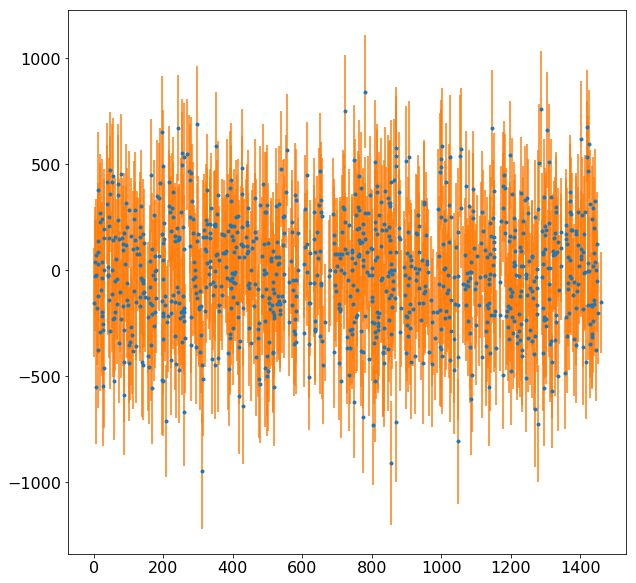

In [ ]:

plt.plot(time,flux,'.')
plt.errorbar(time,flux,yerr=error,linestyle="none")
# plt.xlim(180,181)

In [ ]:
%%time
results = cs.basis_pursuit(time,flux,fmin=0.01,fmax=300,nfreqs=5000,polyorder=4,noise=False)

In [ ]:
power = results['power']
plt.plot(results['freqs']/2./np.pi,power)


In [ ]:
plt.title("Comparison of Data and Model",y=1.01)
plt.plot(time,flux,'.')
plt.plot(time,results['model'],'.')
plt.xlabel("Time (d)")
plt.ylabel("Flux");

In [ ]:
plt.plot(results['diracs'])

In [ ]:
results.keys()